## Running the DEEP AA on the Beta Cells dataset

In [108]:
import sys, scprep, magic, scanpy, sklearn
import warnings; warnings.filterwarnings('ignore')
sys.path.append('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet') # replace with location of AAnet from https://github.com/KrishnaswamyLab/AAnet
from AAnet_torch import * # use torch implementation
import torch; from torch import optim
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from sklearn import decomposition
import os
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
import phate


### Global Setup

In [109]:
np.random.seed(0)
N_ARCHETYPES = 4
N_RUNS = 3
N_EPOCHS = 15
SAVE_DIR = "results/beta_cells/AANET15Epochs"

# make sure save directory exists
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)


### Load the dataset

In [110]:


# 1. Load Data
print("Loading single-cell dataset...")
adata_beta_hfd = scanpy.read_h5ad('data/beta_cells_hfd.h5ad')

print(f"Dataset shape: {adata_beta_hfd.X.shape}")

# Display AnnData summary
display(adata_beta_hfd)

# Show variable names and columns
print("Variable names:", list(adata_beta_hfd.var_names))
print("Variable columns:", list(adata_beta_hfd.var.columns))

# Convert to pandas DataFrame for easier inspection
df_beta_hfd = adata_beta_hfd.to_df()
print("First few rows of the data:")
display(df_beta_hfd.head())


Loading single-cell dataset...
Dataset shape: (3887, 16483)


AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

Variable names: ['ENSMUSG00000109644', 'ENSMUSG00000007777', 'ENSMUSG00000024442', 'ENSMUSG00000042208', 'ENSMUSG00000020831', 'ENSMUSG00000107002', 'ENSMUSG00000046683', 'ENSMUSG00000058706', 'ENSMUSG00000108236', 'ENSMUSG00000028608', 'ENSMUSG00000097882', 'ENSMUSG00000058812', 'ENSMUSG00000089889', 'ENSMUSG00000087341', 'ENSMUSG00000060512', 'ENSMUSG00000087361', 'ENSMUSG00000097863', 'ENSMUSG00000097222', 'ENSMUSG00000090066', 'ENSMUSG00000071456', 'ENSMUSG00000022972', 'ENSMUSG00000030663', 'ENSMUSG00000107121', 'ENSMUSG00000027637', 'ENSMUSG00000021023', 'ENSMUSG00000039195', 'ENSMUSG00000045237', 'ENSMUSG00000028441', 'ENSMUSG00000097616', 'ENSMUSG00000097047', 'ENSMUSG00000099139', 'ENSMUSG00000037971', 'ENSMUSG00000046999', 'ENSMUSG00000044991', 'ENSMUSG00000099098', 'ENSMUSG00000063236', 'ENSMUSG00000085457', 'ENSMUSG00000040591', 'ENSMUSG00000035171', 'ENSMUSG00000032551', 'ENSMUSG00000078570', 'ENSMUSG00000045414', 'ENSMUSG00000043687', 'ENSMUSG00000063320', 'ENSMUSG0000008

ENSMUSG00000109644  ENSMUSG00000007777  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0            0.000000   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0            0.000000   

                             ENSMUSG00000024442  ENSMUSG00000042208  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0            0.000000   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0            1.189718   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0            0.000000   

                             ENSMUSG00000020831  ENSMUSG00000107002  \
AAACCCACAATCGCGC-1_CG11-hfd            0.000000            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd            0.000000            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd            0.867926            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd            0.000000            0.000000   
AAACCCATCTGTTCAT-1_CG11-hfd            0.000000            1.027114   

                             ENSMUSG00000046683  ENSMUSG00000058706  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0            0.000000   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0            0.000000   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0            0.000000   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0            1.189718   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0            0.000000   

                             ENSMUSG00000108236  ENSMUSG00000028608  ...  \
AAACCCACAATCGCGC-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCACACTGGAAG-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCACATGCAGCC-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCACATTGGGAG-1_CG11-hfd                 0.0                 0.0  ...   
AAACCCATCTGTTCAT-1_CG11-hfd                 0.0                 0.0  ...   

                             ENSMUSG00000064354  ENSMUSG00000064358  \
AAACCCACAATCGCGC-1_CG11-hfd            8.602648            8.867407   
AAACCCACACTGGAAG-1_CG11-hfd            5.721965            6.700879   
AAACCCACATGCAGCC-1_CG11-hfd            7.907183            9.895880   
AAACCCACATTGGGAG-1_CG11-hfd            7.801501            8.742604   
AAACCCATCTGTTCAT-1_CG11-hfd           11.889707           12.152979   

                             ENSMUSG00000064370  ENSMUSG00000064341  \
AAACCCACAATCGCGC-1_CG11-hfd            5.268024            3.725056   
AAACCCACACTGGAAG-1_CG11-hfd            5.639630            1.675220   
AAACCCACATGCAGCC-1_CG11-hfd            7.616020            5.420197   
AAACCCACATTGGGAG-1_CG11-hfd            7.617910            4.121303   
AAACCCATCTGTTCAT-1_CG11-hfd           10.821320            6.076489   

                             ENSMUSG00000064345  ENSMUSG00000064360  \
AAACCCACAATCGCGC-1_CG11-hfd            6.451986            3.041495   
AAACCCACACTGGAAG-1_CG11-hfd            3.618888            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd            5.691372            2.125976   
AAACCCACATTGGGAG-1_CG11-hfd            5.705686            1.682515   
AAACCCATCTGTTCAT-1_CG11-hfd            7.617283            2.905118   

                             ENSMUSG00000064363  ENSMUSG00000065947  \
AAACCCACAATCGCGC-1_CG11-hfd            6.451986            2.150662   
AAACCCACACTGGAAG-1_CG11-hfd            4.215877            0.967189   
AAACCCACATGCAGCC-1_CG11-hfd            6.494964            1.735852   
AAACCCACATTGGGAG-1_CG11-hfd            3.762218            1.682515   
AAACCCATCTGTTCAT-1_CG11-hfd            8.087505            1.779014   

                             ENSMUSG00000064367  ENSMUSG00000064368  
AAACCCACAATCGCGC-1_CG11-hfd            2.150662                 0.0  
AAACCCACACTGGAAG

### Subsample

In [111]:
# Dataset is too big, subsample for faster testing
adata_beta_hfd = adata_beta_hfd[:1000, :]
print(f"Subsampled dataset shape: {adata_beta_hfd.X.shape}")

Subsampled dataset shape: (1000, 16483)


### Apply Magic
Result: hfd_magic → imputed gene expression matrix with fewer zeros.

In [112]:
hfd_magic_op = magic.MAGIC(random_state=42, t=10)
hfd_magic = hfd_magic_op.fit_transform(adata_beta_hfd.to_df())

Calculating MAGIC...
  Running MAGIC on 1000 cells and 16483 genes.


  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.16 seconds.
    Calculating affinities...
    Calculated affinities in 0.13 seconds.
  Calculated graph and diffusion operator in 1.10 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.48 seconds.
Calculated MAGIC in 1.66 seconds.


In [113]:
hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")

Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)


### Run AAnet
AAnet performs much better with diffusion extrema initialization 


In [114]:
# Added a transposoition to ensure final shape
X = torch.tensor(hfd_magic_pc_norm, dtype=torch.float64).transpose(0, 1)

extrema = torch.Tensor(utils.get_laplacian_extrema(hfd_magic_pc_norm, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(hfd_magic_pc_norm[extrema.numpy().astype(int)])

In [115]:
device = torch.device('cpu')

In [116]:
data_loader = torch.utils.data.DataLoader(hfd_magic_pc_norm, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
from tqdm import trange

S_list = []
C_list = []
loss_history = []

CHECKPOINTS = [1,3,5,7,9,11,13,15]
checkpoint_results = {ep: {'S_list': [], 'C_list': []} for ep in CHECKPOINTS}

for run in range(N_RUNS):
    print(f"\n{'='*50}")
    print(f"Run {run+1}/{N_RUNS}")
    print(f"{'='*50}")
    
    model = models.AAnet_vanilla(
        noise=0.05,
        layer_widths=[256, 128],
        n_archetypes=N_ARCHETYPES,
        input_shape=hfd_magic_pc_norm.shape[1],
        device=device,
        diffusion_extrema=extrema
    )
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    run_losses = []
    
    for epoch in trange(1, N_EPOCHS + 1, desc=f"Training Run {run+1}", leave=True):
        loss, r_loss, a_loss = utils.train_epoch(model, data_loader, optimizer, epoch=epoch, gamma_extrema=1.0)
        run_losses.append(loss)
        
        if epoch % 2 == 0 or epoch == 1:
            print(f"  Epoch {epoch:2d} | Loss: {loss:.6f} | R_loss: {r_loss:.6f} | A_loss: {a_loss:.6f}")
        
        if epoch in CHECKPOINTS:
            archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm)).detach().numpy()
            barycentric_embedding = model.euclidean_to_barycentric(torch.Tensor(archetypal_embedding)).detach().numpy()
            S_T = barycentric_embedding.T
            C = S_T.T
            checkpoint_results[epoch]['S_list'].append(S_T)
            checkpoint_results[epoch]['C_list'].append(C)
    
    loss_history.append(run_losses)
    
    archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm)).detach().numpy()
    barycentric_embedding = model.euclidean_to_barycentric(torch.Tensor(archetypal_embedding)).detach().numpy()
    S_T = barycentric_embedding.T
    C = S_T.T
    S_list.append(S_T)
    C_list.append(C)
    
    print(f"\n✓ Run {run+1} complete - S shape: {S_T.shape}, C shape: {C.shape}")
    
    np.savez(os.path.join(SAVE_DIR, f'run{run+1}_results.npz'), S=S_T, C=C, X=hfd_magic_pc_norm, losses=run_losses)

torch.save({
    'S_list': S_list,
    'C_list': C_list,
    'X': hfd_magic_pc_norm,
    'loss_history': loss_history,
    'checkpoint_results': checkpoint_results
}, os.path.join(SAVE_DIR, 'AAnet_singlecell_runs.pth'))

torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'AAnet_model_last_run.pth'))

print(f"\n{'='*50}")
print(f"✅ Saved all {N_RUNS} runs results.")
print(f"{'='*50}")



📊 Plotting training curves...


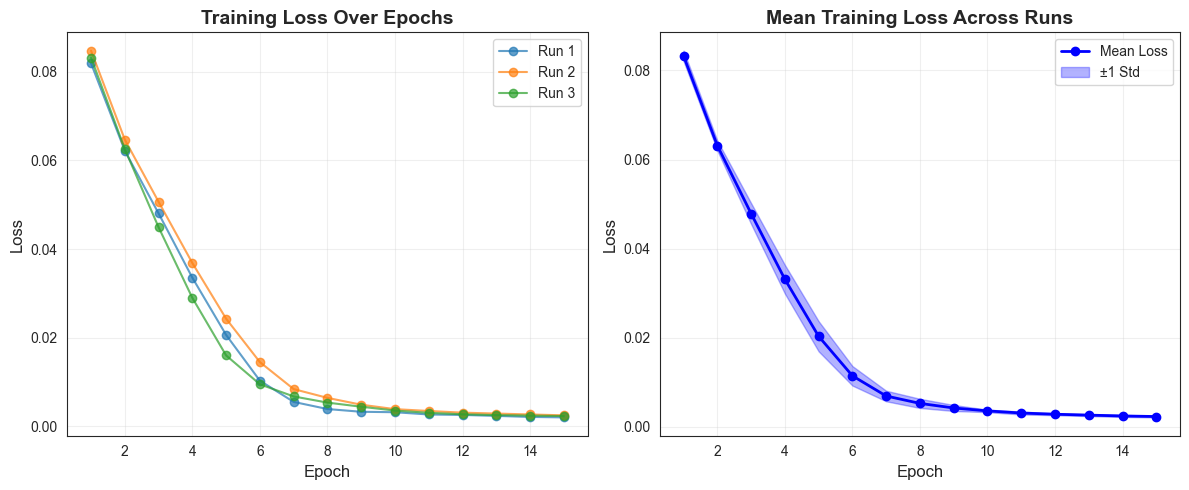

Final Loss after 15 epochs:
  Run 1: 0.002003
  Run 2: 0.002466
  Run 3: 0.002309


In [117]:

# =========================================
# VISUALIZE TRAINING PROGRESS
# =========================================

print("\n📊 Plotting training curves...")

loss_history = results['loss_history']

# 1. Plot Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, losses in enumerate(loss_history):
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f'Run {i+1}', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Plot Average Loss ± Std
plt.subplot(1, 2, 2)
loss_array = np.array(loss_history)
mean_loss = loss_array.mean(axis=0)
std_loss = loss_array.std(axis=0)
epochs = np.arange(1, N_EPOCHS + 1)

plt.plot(epochs, mean_loss, marker='o', linewidth=2, color='blue', label='Mean Loss')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, 
                 alpha=0.3, color='blue', label='±1 Std')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Mean Training Loss Across Runs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_loss_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print the final loss
print(f"Final Loss after {N_EPOCHS} epochs:")
for i, losses in enumerate(loss_history):
    print(f"  Run {i+1}: {losses[-1]:.6f}")


## Visualize the Results

In [118]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/beta_Cells/AANET15Epochs/AAnet_singlecell_runs.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C_list']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C_list'][0].shape)
print("Shape of S in first run:", results['S_list'][0].shape)
print('Shape of X in first run:', results['X'].shape)

Saved Results Keys: dict_keys(['S_list', 'C_list', 'X', 'loss_history', 'checkpoint_results'])
Number of Runs Saved: 3
Shape of C in first run: (1000, 4)
Shape of S in first run: (4, 1000)
Shape of X in first run: (1000, 20)


# Metric Formulas

In [119]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [105]:

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C_list']]
print("C_matrices length:", len(C_matrices))
print("C_matrices[0] shape:", C_matrices[0].shape)
S_matrices = [to_numpy(S) for S in results['S_list']]
print("S_matrices length:", len(S_matrices))
print("S_matrices[0] shape:", S_matrices[0].shape)

loss_histories = results['loss_history']
# Select best run based on final loss
best_run_idx = np.argmin([losses[-1] for losses in loss_histories])
C_linear_best = C_matrices[best_run_idx]  # (n_samples, n_archetypes)
S_linear_best = S_matrices[best_run_idx]  # (n_archetypes, n_samples)
print(f"Best run index: {best_run_idx}")
print(f"C_linear_best shape: {C_linear_best.shape}")
print(f"S_linear_best shape: {S_linear_best.shape}")

X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Deep AANET AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 3
C_matrices[0] shape: (1000, 4)
S_matrices length: 3
S_matrices[0] shape: (4, 1000)
Best run index: 0
C_linear_best shape: (1000, 4)
S_linear_best shape: (4, 1000)
---
Deep AANET AA 5-run stability:
---
Mean NMI: 0.9844768101880669
Mean Archetype Consistency: 0.953064908214256
Mean ISI: 0.3759222979014667


---

#### AAnet training results in the following useful outputs:

`barycentric_archetypal_embedding: n_obs x n_ats`: Archetypal affinity for each cell.  
`pc_ats: n_ats x n_pcs`: Embedding for each archetype based on input embedding (here we used PCs).   
`data_ats: n_ats x n_genes`: Ambient space measurement for each archetype by inverse transforming from PC space.

In [106]:
model = models.AAnet_vanilla(
    noise=0.05,
    layer_widths=[256, 128],
    n_archetypes=N_ARCHETYPES,
    input_shape=hfd_magic_pc_norm.shape[1],
    device=device,
    diffusion_extrema=extrema
)
archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm))
print("Archetypal Embedding Shape:", archetypal_embedding.shape)
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
print("Barycentric Embedding Shape:", barycentric_archetypal_embedding.shape)
pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
print("PC Archetypes Shape:", pc_ats.shape)
data_ats = ((pc_ats
             * np.std(hfd_magic_pc[:,0])) @ hfd_pc_op.components_)
print("Data Archetypes Shape:", data_ats.shape)

np.savez(os.path.join(SAVE_DIR, 'Beta_cell_AAnet_results.npz'),
         data_ats=data_ats,
         latent_coords=barycentric_archetypal_embedding)


Archetypal Embedding Shape: torch.Size([1000, 3])
Barycentric Embedding Shape: (1000, 4)
PC Archetypes Shape: (4, 20)
Data Archetypes Shape: (4, 16483)


---

# Archetypal Analysis

In [107]:
# =============================================================================
# 5. EXTRACT ARCHETYPE GENE EXPRESSIONS (from last run)
# =============================================================================
print("\n" + "="*60)
print("Extracting archetype gene expressions...")
print("="*60)

# Get archetype embeddings in PCA space
pc_ats = model.decode(
    model.get_n_simplex(model.n_archetypes).type(torch.float)
).cpu().detach().numpy()

# Transform back to gene space
# Denormalize and inverse PCA transform
import numpy as np  # Ensure numpy is imported

# Use hfd_magic_pc_norm for normalization, which is a numpy array
pc_ats_denorm = pc_ats * np.std(hfd_magic_pc_norm[:, 0])
data_ats = (pc_ats_denorm @ hfd_pc_op.components_) + hfd_pc_op.mean_

print(f"Archetype PCA embeddings shape: {pc_ats.shape}")
print(f"Archetype gene expressions shape: {data_ats.shape}")



Extracting archetype gene expressions...
Archetype PCA embeddings shape: (4, 20)
Archetype gene expressions shape: (4, 16483)


In [94]:
# =============================================================================
# 6. COMPUTE PHATE FOR VISUALIZATION
# =============================================================================
print("\n" + "="*60)
print("Computing PHATE embedding...")
print("="*60)

X_magic = hfd_magic_pc_norm  # Use the normalized PCA data for PHATE

phate_op = phate.PHATE(n_jobs=-1, random_state=42, verbose=False)
data_phate = phate_op.fit_transform(X_magic)
print(f"PHATE embedding shape: {data_phate.shape}")

# Store in adata

adata_beta_hfd.obsm['X_phate'] = data_phate
adata_beta_hfd.obsm['X_pca_aanet'] = hfd_magic_pc_norm
adata_beta_hfd.obsm['AAnet_weights'] = barycentric_archetypal_embedding
adata_beta_hfd.uns['AAnet_archetypes_pc'] = pc_ats
adata_beta_hfd.uns['AAnet_archetypes_genes'] = data_ats

# Save annotated adata
adata_beta_hfd.write(os.path.join(SAVE_DIR, 'adata_with_aanet.h5ad'))
print(f"✓ Saved annotated AnnData")


Computing PHATE embedding...
PHATE embedding shape: (1000, 2)


ValueError: Value passed for key 'X_phate' is of incorrect shape. Values of obsm must match dimensions ('obs',) of parent. Value had shape (1000,) while it should have had (3887,).

In [ ]:
hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")

Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)



Generating quick visualizations...
✓ Saved training overview
✓ Saved PHATE visualization

✅ COMPLETE! All results saved to: results/beta_cells/AANET

Next steps:
1. Run the Figure 8 visualization script
2. Adjust N_ARCHETYPES if needed (try 4-8)
3. Select appropriate marker genes for your dataset
Reconstruction MSE: 0.059426
Reconstruction RMSE: 0.243774
Reconstruction R2: -0.084556


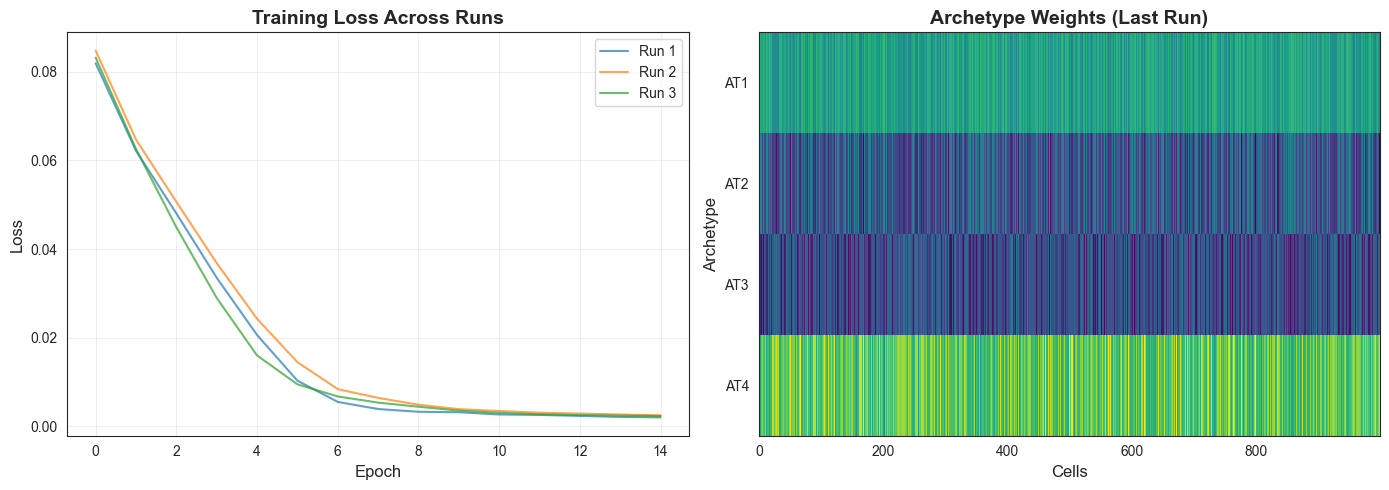

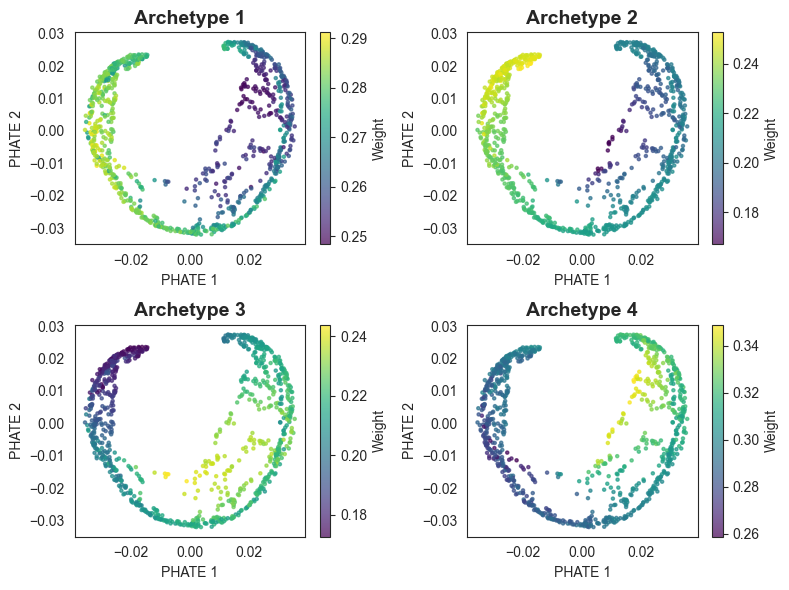

In [95]:

# =============================================================================

print("\n" + "="*60)
print("Generating quick visualizations...")
print("="*60)

# Use loss_histories variable directly, since results['loss_history'] may not exist

loss_histories = results['loss_history']

barycentric_embedding = barycentric_archetypal_embedding


# Plot training losses
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for run_idx, losses in enumerate(loss_histories):
    ax.plot(losses, alpha=0.7, label=f'Run {run_idx+1}')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Across Runs', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot archetype weights
ax = axes[1]
ax.imshow(barycentric_embedding.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Cells', fontsize=12)
ax.set_ylabel('Archetype', fontsize=12)
ax.set_title('Archetype Weights (Last Run)', fontsize=14, fontweight='bold')
ax.set_yticks(range(N_ARCHETYPES))
ax.set_yticklabels([f'AT{i+1}' for i in range(N_ARCHETYPES)])

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_overview.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved training overview")

# Plot PHATE with archetype weights
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i in range(min(N_ARCHETYPES, 6)):
    ax = axes[i]
    scatter = ax.scatter(data_phate[:, 0], data_phate[:, 1],
                        c=barycentric_embedding[:, i], 
                        cmap='viridis', s=5, alpha=0.7)
    ax.set_title(f'Archetype {i+1}', fontsize=14, fontweight='bold')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    plt.colorbar(scatter, ax=ax, label='Weight')

for i in range(N_ARCHETYPES, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'phate_archetypes.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved PHATE visualization")

print("\n" + "="*60)
print("✅ COMPLETE! All results saved to:", SAVE_DIR)
print("="*60)
print("\nNext steps:")
print("1. Run the Figure 8 visualization script")
print("2. Adjust N_ARCHETYPES if needed (try 4-8)")
print("3. Select appropriate marker genes for your dataset")
print("="*60)

# Reconstruction metrics: MSE, RMSE, R2
X_recon = model.decode(model.encode(torch.Tensor(hfd_magic_pc_norm))).detach().numpy()

mse_recon = np.mean((X_recon - hfd_magic_pc_norm) ** 2)
rmse_recon = np.sqrt(mse_recon)
ss_res = np.sum((hfd_magic_pc_norm - X_recon) ** 2)
ss_tot = np.sum((hfd_magic_pc_norm - np.mean(hfd_magic_pc_norm)) ** 2)
r2_recon = 1 - ss_res / ss_tot

print(f"Reconstruction MSE: {mse_recon:.6f}")
print(f"Reconstruction RMSE: {rmse_recon:.6f}")
print(f"Reconstruction R2: {r2_recon:.6f}")

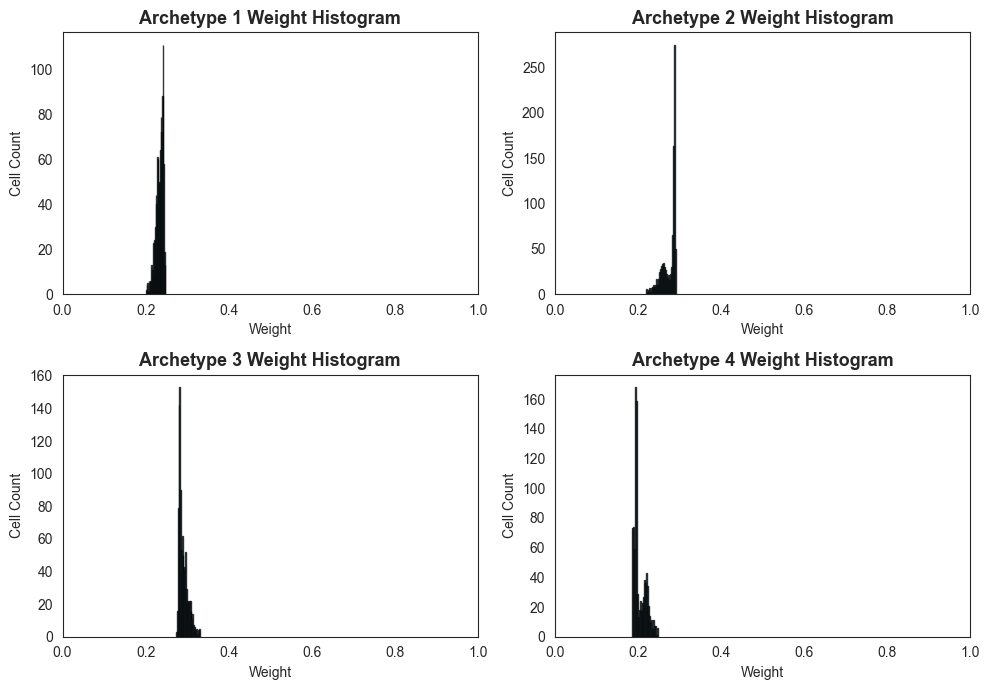

✓ Saved archetype weight histograms


<Figure size 640x480 with 0 Axes>

In [102]:
# Plot histogram of archetype weights for each archetype
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()
for i in range(N_ARCHETYPES):
    ax = axes[i]
    ax.hist(barycentric_embedding[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.8)
    ax.set_title(f'Archetype {i+1} Weight Histogram', fontsize=13, fontweight='bold')
    ax.set_xlabel('Weight')
    ax.set_ylabel('Cell Count')
    ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(SAVE_DIR, 'archetype_weight_histograms.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved archetype weight histograms")


Loading data and results...
Original dataset shape: (3887, 16483)
Archetypes shape: (4, 16483)
Barycentric embedding shape: (1000, 4)

Calculating PHATE embedding on full dataset...
Calculating PHATE...
  Running PHATE on 3887 observations and 16483 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.27 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 3.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.23 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.32 seconds.
  Calculated landmark operator in 3.55 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 1.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
    SG

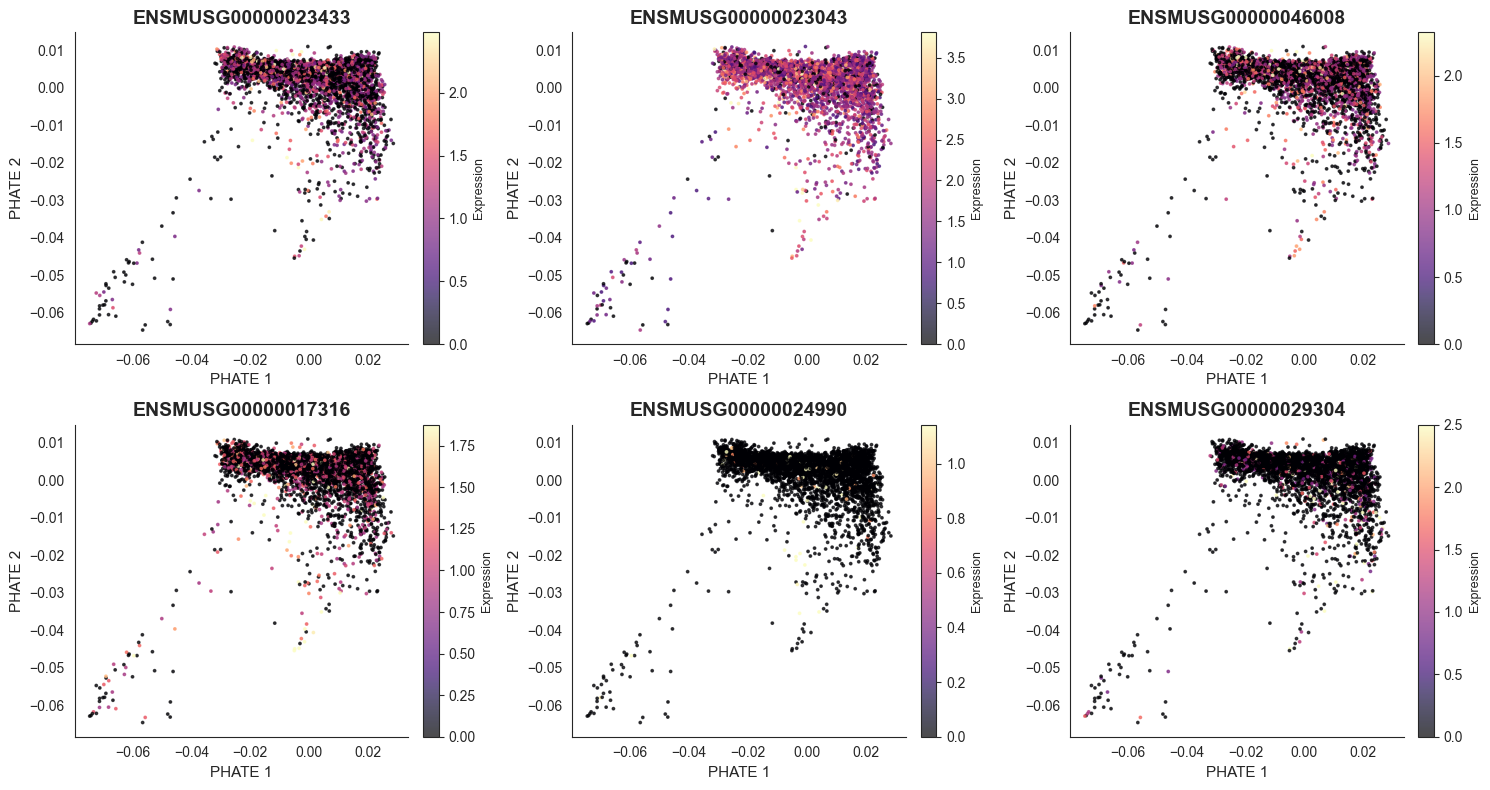

✓ Saved Figure 8a

Creating Figure 8b: Archetype gene signatures (scale 0-100)...


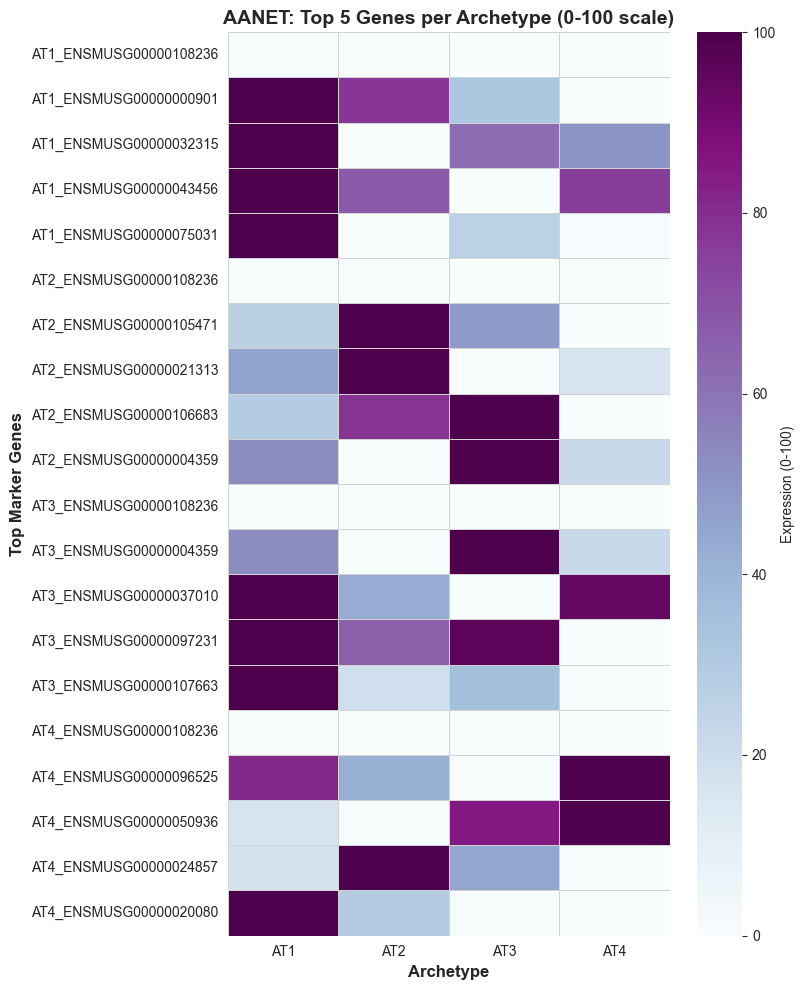

✓ Saved Figure 8b

Top genes per archetype (percentile):

Archetype 1:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000000901: 100.0th percentile
  ENSMUSG00000032315: 100.0th percentile
  ENSMUSG00000043456: 100.0th percentile
  ENSMUSG00000075031: 100.0th percentile

Archetype 2:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000105471: 100.0th percentile
  ENSMUSG00000021313: 100.0th percentile
  ENSMUSG00000106683: 100.0th percentile
  ENSMUSG00000004359: 100.0th percentile

Archetype 3:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000004359: 100.0th percentile
  ENSMUSG00000037010: 100.0th percentile
  ENSMUSG00000097231: 100.0th percentile
  ENSMUSG00000107663: 100.0th percentile

Archetype 4:
  ENSMUSG00000108236: 100.0th percentile
  ENSMUSG00000096525: 100.0th percentile
  ENSMUSG00000050936: 100.0th percentile
  ENSMUSG00000024857: 100.0th percentile
  ENSMUSG00000020080: 100.0th percentile

Creating bonus figure: Archetype weights on PHATE...
Note: Using f

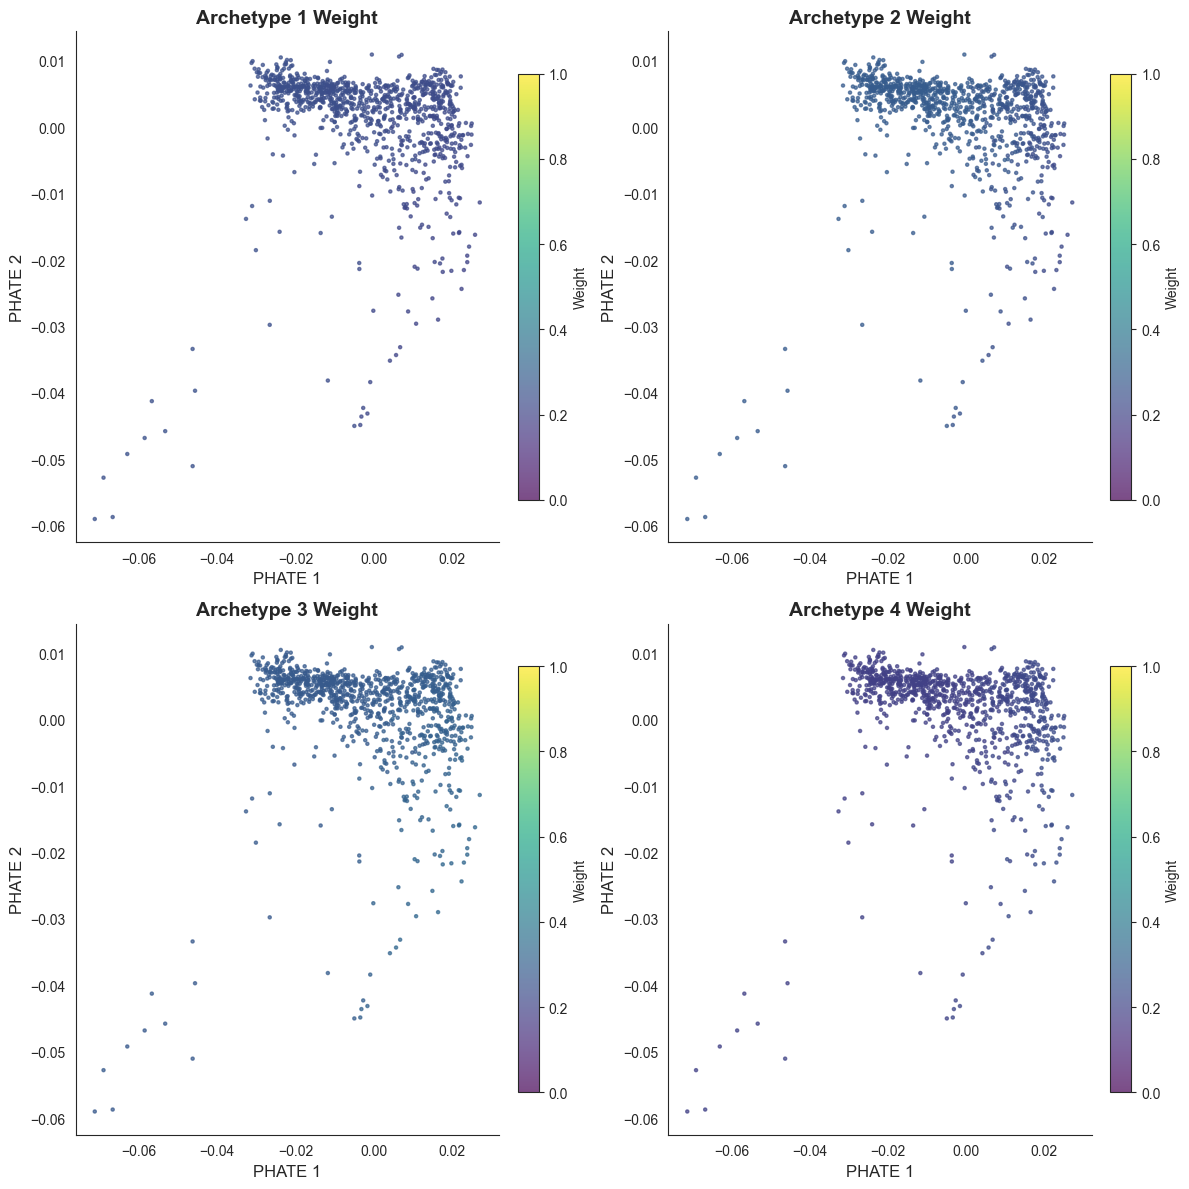

✓ Saved archetype weights on PHATE

All Figure 8 visualizations complete!
Results saved to: results/beta_cells/AANET


In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import phate
import torch
from scipy.spatial.distance import cdist
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set style
sns.set_style('white')
plt.rcParams['font.size'] = 10

# =============================================================================
# LOAD YOUR EXISTING RESULTS
# =============================================================================
print("Loading data and results...")

# Load original dataset
adata_beta_hfd = sc.read_h5ad('data/beta_cells_hfd.h5ad')
print(f"Original dataset shape: {adata_beta_hfd.X.shape}")

# Load your saved AAnet results (PyTorch checkpoint)
results_path = 'results/beta_cells/AANET/AAnet_singlecell_runs.pth'
results = torch.load(results_path, weights_only=False)

# Load the saved model outputs (archetypes and barycentric embedding)
saved_results = np.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/beta_Cells/AANET15Epochs/Beta_cell_AAnet_results.npz')
data_ats = saved_results['data_ats']  # Archetype gene expressions
barycentric_embedding = saved_results['latent_coords']  # Cell weights

print(f"Archetypes shape: {data_ats.shape}")
print(f"Barycentric embedding shape: {barycentric_embedding.shape}")

# Get the last run's C matrix for consistency
C_last = results['C_list'][-1]  # Shape: (samples, archetypes)
S_last = results['S_list'][-1]  # Shape: (archetypes, samples)
X_pca = results['X']  # PCA-transformed data

N_ARCHETYPES = data_ats.shape[0]
SAVE_DIR = "results/beta_cells/AANET"

# =============================================================================
# COMPUTE PHATE ON FULL DATASET
# =============================================================================
print("\nCalculating PHATE embedding on full dataset...")
phate_op = phate.PHATE(n_jobs=-1, random_state=42)

# Apply PHATE to the original data (or magic-imputed if you prefer)
if hasattr(adata_beta_hfd.X, 'toarray'):
    X_full = adata_beta_hfd.X.toarray()
else:
    X_full = adata_beta_hfd.X

data_phate_full = phate_op.fit_transform(X_full)

# =============================================================================
# FIGURE 8a: PHATE with marker gene expression
# =============================================================================
print("\nCreating Figure 8a: PHATE with marker genes...")

marker_genes=[]

if len(marker_genes) == 0:
    print("Warning: No marker genes found. Using top variable genes instead.")
    sc.pp.highly_variable_genes(adata_beta_hfd, n_top_genes=6)
    marker_genes = adata_beta_hfd.var_names[adata_beta_hfd.var['highly_variable']][:6].tolist()

print(f"Using marker genes: {marker_genes}")

n_markers = len(marker_genes)
n_cols = 3
n_rows = (n_markers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, gene in enumerate(marker_genes):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    # Get gene expression
    gene_idx = adata_beta_hfd.var_names.tolist().index(gene)
    if hasattr(adata_beta_hfd.X, 'toarray'):
        expr = adata_beta_hfd.X[:, gene_idx].toarray().flatten()
    else:
        expr = adata_beta_hfd.X[:, gene_idx]
    
    # Plot
    scatter = ax.scatter(data_phate_full[:, 0], data_phate_full[:, 1],
                        c=expr, cmap='magma', s=3, alpha=0.7,
                        vmin=np.percentile(expr, 1),
                        vmax=np.percentile(expr, 99))
    
    ax.set_title(f'{gene}', fontsize=14, fontweight='bold')
    ax.set_xlabel('PHATE 1', fontsize=11)
    ax.set_ylabel('PHATE 2', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Expression', fontsize=9)

# Remove extra subplots
for idx in range(n_markers, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()
plt.savefig(f'{SAVE_DIR}/fig8a_phate_markers.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/fig8a_phate_markers.pdf', bbox_inches='tight')
print(f"✓ Saved Figure 8a")
plt.close()

# =============================================================================
# FIGURE 8b: Top 5 marker genes for each archetype (scale 0-100)
# =============================================================================
print("\nCreating Figure 8b: Archetype gene signatures (scale 0-100)...")

gene_names = adata_beta_hfd.var_names.tolist()
top_k = 5

all_top_genes = []
heatmap_data = []

for i in range(N_ARCHETYPES):
    archetype_expr = data_ats[i, :]
    percentiles = np.array([(X_full[:, j] < archetype_expr[j]).sum() / len(X_full) * 100 
                           for j in range(len(archetype_expr))])
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    for rank, idx in enumerate(top_indices):
        gene = gene_names[idx]
        all_top_genes.append(f"AT{i+1}_{gene}")
        expr_values = [data_ats[j, idx] for j in range(N_ARCHETYPES)]
        heatmap_data.append(expr_values)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data, 
                         index=all_top_genes,
                         columns=[f'AT{i+1}' for i in range(N_ARCHETYPES)])

# Normalize to 0-100 scale per row
min_vals = heatmap_df.min(axis=1)
max_vals = heatmap_df.max(axis=1)
heatmap_df_norm = (heatmap_df.sub(min_vals, axis=0)
                   .div(max_vals - min_vals + 1e-10, axis=0)
                   .mul(100))

fig, ax = plt.subplots(figsize=(8, max(10, top_k * N_ARCHETYPES * 0.4)))
sns.heatmap(heatmap_df_norm, cmap='BuPu', center=50, 
            cbar_kws={'label': 'Expression (0-100)'},
            linewidths=0.5, linecolor='lightgray',
            ax=ax, vmin=0, vmax=100, yticklabels=True)
ax.set_xlabel('Archetype', fontsize=12, fontweight='bold')
ax.set_ylabel('Top Marker Genes', fontsize=12, fontweight='bold')
ax.set_title(f'AANET: Top {top_k} Genes per Archetype (0-100 scale)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()  
plt.savefig(f'{SAVE_DIR}/fig8b_gene_signatures.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/fig8b_gene_signatures.pdf', bbox_inches='tight')
print(f"✓ Saved Figure 8b")
plt.close()

print("\nTop genes per archetype (percentile):")
for i in range(N_ARCHETYPES):
    archetype_expr = data_ats[i, :]
    percentiles = np.array([(X_full[:, j] < archetype_expr[j]).sum() / len(X_full) * 100 
                           for j in range(len(archetype_expr))])
    top_indices = np.argsort(percentiles)[-top_k:][::-1]
    print(f"\nArchetype {i+1}:")
    for idx in top_indices:
        gene = gene_names[idx]
        print(f"  {gene}: {percentiles[idx]:.1f}th percentile")


# =============================================================================
# BONUS: Archetype weights on PHATE
# =============================================================================
print("\nCreating bonus figure: Archetype weights on PHATE...")

# Note: barycentric_embedding is from subsampled data (1000 cells)
# We need to match this to the full PHATE embedding
if barycentric_embedding.shape[0] == adata_beta_hfd.shape[0]:
    weights = barycentric_embedding
    phate_coords = data_phate_full
else:
    # If using subsampled data, compute PHATE on that subset
    print(f"Note: Using first {barycentric_embedding.shape[0]} cells for weight visualization")
    weights = barycentric_embedding
    phate_coords = data_phate_full[:barycentric_embedding.shape[0], :]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(N_ARCHETYPES, 6)):
    ax = axes[i]
    
    scatter = ax.scatter(phate_coords[:, 0], phate_coords[:, 1],
                        c=weights[:, i], cmap='viridis',
                        s=5, alpha=0.7, vmin=0, vmax=1)
    
    ax.set_title(f'Archetype {i+1} Weight', fontsize=14, fontweight='bold')
    ax.set_xlabel('PHATE 1', fontsize=12)
    ax.set_ylabel('PHATE 2', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Weight', fontsize=10)

# Remove extra subplots
for i in range(N_ARCHETYPES, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
plt.savefig(f'{SAVE_DIR}/archetype_weights_phate.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{SAVE_DIR}/archetype_weights_phate.pdf', bbox_inches='tight')
print(f"✓ Saved archetype weights on PHATE")
plt.close()

print("\n" + "="*60)
print("All Figure 8 visualizations complete!")
print(f"Results saved to: {SAVE_DIR}")
print("="*60)